In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
from modules import *

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0
    for cur_layer_x, cur_layer_dx in zip(x,dx):
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

## Toy artificial example

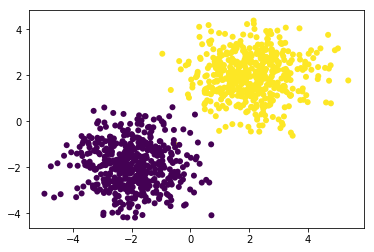

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1, X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
plt.show()

In [5]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



In [6]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

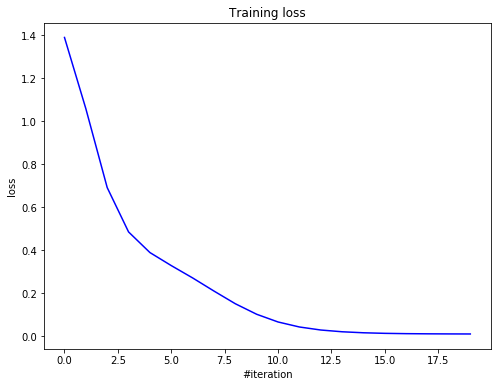

Current loss: 0.010859


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

## Digit classification

(Good old MNIST dataset)

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)

# mnist.data, mnist.target
X, y = mnist.data / 255.0, list(map(int, mnist.target))

In [10]:
import pandas as pd

Y = pd.get_dummies(y).values.astype(float)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

In [12]:
def construct_net(activation_routine, use_batch_norm=False):
    net = Sequential()
    net.add(Linear(784, 784))
    if use_batch_norm:
        net.add(BatchNormalization(alpha=0.2))
        net.add(ChannelwiseScaling(n_out=784))
    net.add(activation_routine())
    net.add(Linear(784, 10))
    net.add(LogSoftMax())
    return net

In [13]:
def compute_train_test_losses(net, criterion):
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    n_epoch = 20
    batch_size = 1000
    
    loss_train_history, loss_test_history = [], []
    for i in range(n_epoch):
        net.train()
        
        last_train_loss = None
        
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()
            
            predictions = net.forward(x_batch)
            train_loss = criterion.forward(predictions, y_batch)
            last_train_loss = train_loss
            
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
        loss_train_history.append(last_train_loss)

        net.evaluate()
        test_loss = criterion.forward(net.forward(X_test), Y_test)
        loss_test_history.append(test_loss)

    return loss_train_history, loss_test_history

In [14]:
# Search for the best activation func

activation_routines = [ReLU, ELU, LeakyReLU, SoftPlus]
batch_norm_choices = [True, False]
criterion = ClassNLLCriterion()

train_losses = {}
test_losses = {}

for activation_routine in activation_routines:
    for batch_norm_choice in batch_norm_choices:
        activation_routine_name = str(activation_routine())
        key = (activation_routine_name, batch_norm_choice)        
        print(activation_routine_name, batch_norm_choice)

        net = construct_net(activation_routine, use_batch_norm=batch_norm_choice)
        %time loss_train_history, loss_test_history = compute_train_test_losses(net, criterion)

        train_losses[key] = loss_train_history
        test_losses[key] = loss_test_history

ReLU True
CPU times: user 5min 10s, sys: 15 s, total: 5min 25s
Wall time: 2min
ReLU False
CPU times: user 4min 17s, sys: 9.35 s, total: 4min 26s
Wall time: 1min 16s
ELU True
CPU times: user 5min 11s, sys: 14.9 s, total: 5min 26s
Wall time: 2min 12s
ELU False
CPU times: user 5min 2s, sys: 7.83 s, total: 5min 9s
Wall time: 1min 35s
LeakyReLU True
CPU times: user 5min 16s, sys: 15.9 s, total: 5min 32s
Wall time: 2min 5s
LeakyReLU False
CPU times: user 4min 27s, sys: 6.35 s, total: 4min 34s
Wall time: 1min 15s
SoftPlus True
CPU times: user 5min 13s, sys: 13.6 s, total: 5min 27s
Wall time: 2min 11s
SoftPlus False
CPU times: user 4min 59s, sys: 6.07 s, total: 5min 6s
Wall time: 1min 37s


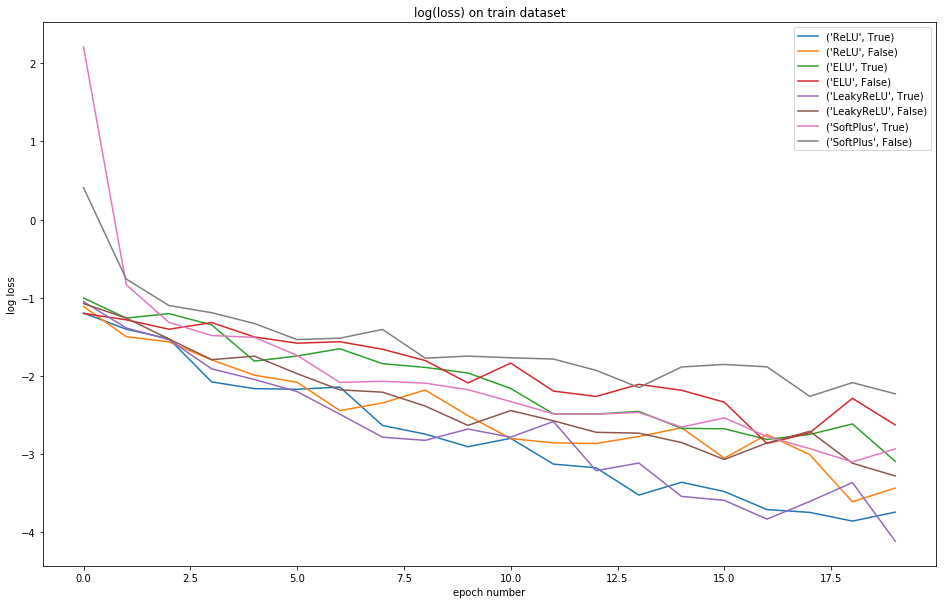

In [15]:
plt.figure(figsize=(16,10))
plt.title('log(loss) on train dataset')
for key, train_losses_hist in train_losses.items():
    plt.plot(np.log(train_losses_hist), label=key)
plt.xlabel('epoch number')
plt.ylabel('log loss')
plt.legend()
plt.show()

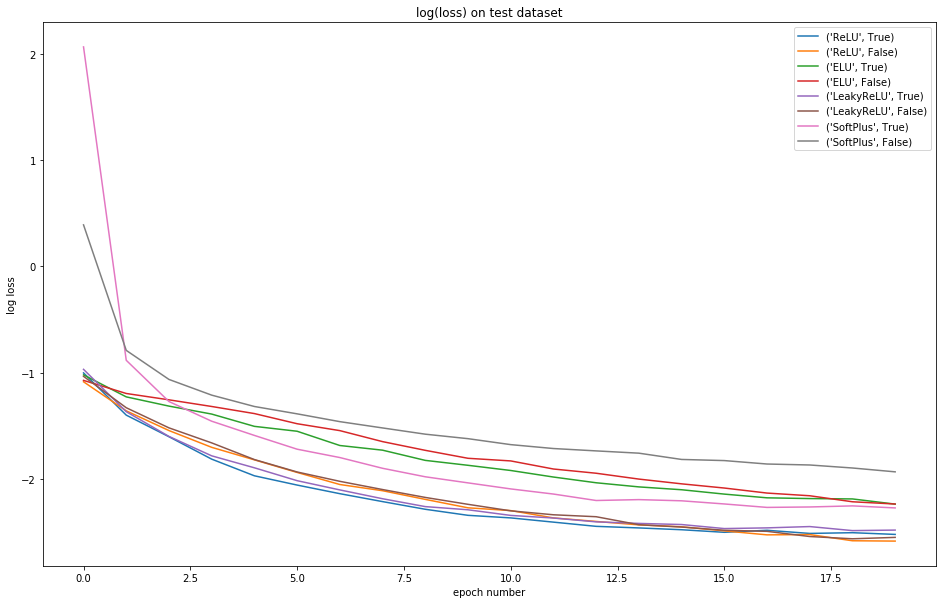

In [16]:
plt.figure(figsize=(16,10))
plt.title('log(loss) on test dataset')
for key, test_losses_hist in test_losses.items():
    plt.plot(np.log(test_losses_hist), label=key)
plt.xlabel('epoch number')
plt.ylabel('log loss')
plt.legend()
plt.show()

#### Best results on test with ReLU and LeakyReLU:

In [17]:
for key, val in test_losses.items():
    print(key, val[-1])

('ReLU', True) 0.08036359508275304
('ReLU', False) 0.07547120644110798
('ELU', True) 0.10687352837277948
('ELU', False) 0.10697456011459333
('LeakyReLU', True) 0.08370470899283908
('LeakyReLU', False) 0.07815408878724335
('SoftPlus', True) 0.10311443231171151
('SoftPlus', False) 0.14480432976994953


In [18]:
from torchvision import transforms
from PIL import Image

In [19]:
class ImgTransformation(object):
    def __init__(self, rotation=15, shift=1):
        self.rotation_routine = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(rotation),
        ])
        self.shift = shift
    
    # get numpy img: w,h,c, 0->255
    # return numpy img after transformation
    def __call__(self, img):
        pil_img = self.rotation_routine(img)
        width_shift = np.random.choice((-self.shift-1, self.shift+1))
        height_shift = np.random.choice((-self.shift-1, self.shift+1))
        transition = (1, 0, width_shift, 0, 1, height_shift)
        pil_img = pil_img.transform(pil_img.size, Image.AFFINE, transition)
        return np.array(pil_img)
    
class BatchTransformation(object):
    def __init__(self, side=28):
        self.img_transformation = ImgTransformation(5,0)
        self.side = side
        self.size = side * side
    
    def transform(self, X):
        X_transformed = np.copy(X)
        for i, np_img_line in enumerate(X_transformed):
            img = (np_img_line.reshape(self.side,self.side,1) * 255).astype(np.float32)
            X_transformed[i] = self.img_transformation(img).reshape(self.size) / 255
        return X_transformed

In [20]:
# data augmentation
batch_transformation = BatchTransformation()

# batch generator
def get_batches(dataset, batch_size, with_augmentation=False):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
        X_result = None
        if with_augmentation:
            X_result = batch_transformation.transform(X[batch_idx])
        else:
            X_result = X[batch_idx]

        yield X_result, Y[batch_idx]

In [21]:
def construct_best_net():
    net = Sequential()
    net.add(Linear(784, 784))
    
    net.add(BatchNormalization(alpha=0.2))
    net.add(ChannelwiseScaling(n_out=784))
    
    net.add(ReLU())
    
    net.add(Dropout(0.4))
    
    net.add(Linear(784, 10))
    net.add(LogSoftMax())
    return net

In [22]:
def fit_net(net, criterion, optimizer_config, optimizer_state, n_epoch, batch_size,
            with_augmentation,
            X_train, Y_train, X_test=None, Y_test=None):
    is_lr_updating = 'lr_factor' in optimizer_config
    is_with_validation = (X_test is not None) and (Y_test is not None)

    loss_train_history, loss_test_history, acc_test_history = [], [], []
    for i in range(n_epoch):
        if is_lr_updating and (i > 0) and (i % optimizer_config['lr_n_epoch_update'] == 0):
            optimizer_config['learning_rate'] /= optimizer_config['lr_factor']
        
        batch_train_losses = []
        net.train()
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size, with_augmentation):
            net.zeroGradParameters()

            predictions = net.forward(x_batch)
            train_loss = criterion.forward(predictions, y_batch)
            batch_train_losses.append(train_loss)

            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

        if len(batch_train_losses) > 0:
            loss_train_history.append(np.mean(batch_train_losses))

        if is_with_validation:
            net.evaluate()
            test_predictions = net.forward(X_test)
            test_loss = criterion.forward(test_predictions, Y_test)
            loss_test_history.append(test_loss)

            test_acc = sum(test_predictions.argmax(axis=1) == Y_test.argmax(axis=1)) / Y_test.shape[0]
            acc_test_history.append(test_acc)

        # Visualize
        display.clear_output(wait=True)
        f, axs = plt.subplots(1, 3 if is_with_validation else 1, figsize=(16,4))
        for i, (ylabel, title, history) in enumerate([['loss', 'Training loss', loss_train_history],
                                                      ['loss', 'Test loss', loss_test_history],
                                                      ['accuracy', 'Test accuracy', acc_test_history]]):
            ax = axs[i] if is_with_validation else axs
            ax.plot(history)
            ax.set_title(title)
            ax.set_xlabel("#epoch")
            ax.set_ylabel(ylabel)
            if not is_with_validation:
                break
        plt.show()

        print('current train loss: {0:.4f}'.format(loss_train_history[-1]))
        if is_with_validation:
            print('test loss: {0:.4f}, test acc: {1:.4f}'.format(loss_test_history[-1],
                                                                 acc_test_history[-1]))
    return loss_train_history, loss_test_history, acc_test_history

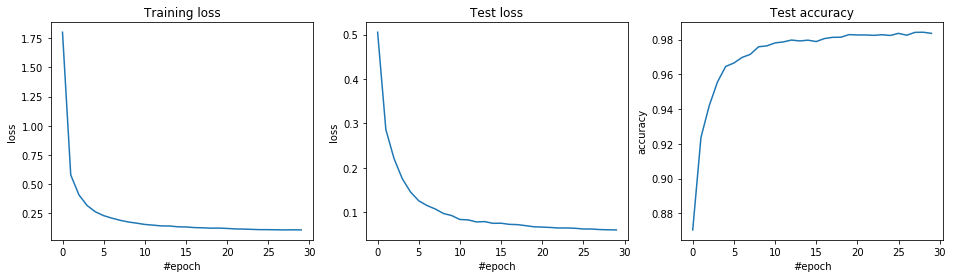

current train loss: 0.1064
test loss: 0.0606, test acc: 0.9836


In [23]:
net = construct_best_net()
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 1e-1,
                    'momentum': 0.9,
                    'lr_factor': 2.0,
                    'lr_n_epoch_update': 10}
optimizer_state = {}
n_epoch = 30
batch_size = 1000

_ = fit_net(net, criterion, optimizer_config, optimizer_state, n_epoch, batch_size,
        True, X_train, Y_train, X_test=X_test, Y_test=Y_test)

### Autoencoder

The aim is simple: **encode** the data to a lower dimentional representation. **Decode** this representation back to original data. It can be used in many applications, from compression to classification tasks.

Make this architecture:

$$784 -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

In [24]:
def get_autoencoder():
    layer_sizes = [784, 512, 256, 128, 30, 128, 256, 512, 784]

    net = Sequential()
    for n_inp, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        net.add(Linear(n_inp, n_out))
        net.add(BatchNormalization(alpha=0.3))
        net.add(ChannelwiseScaling(n_out))
        net.add(ReLU())
    return net

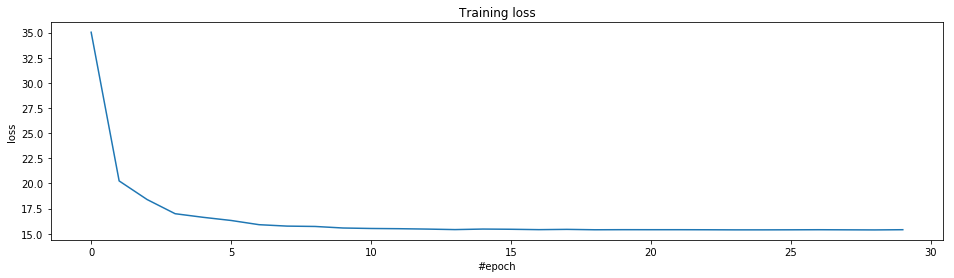

current train loss: 15.4061


In [25]:
autoencoder = get_autoencoder()
criterion = MSECriterion()
optimizer_config = {'learning_rate' : 0.01,
                    'momentum': 0.9,
                    'lr_factor': 3.0,
                    'lr_n_epoch_update': 3}
optimizer_state = {}
n_epoch = 30
batch_size = 128

_ = fit_net(autoencoder, criterion, optimizer_config, optimizer_state, n_epoch, batch_size,
        False, X_train, X_train, X_test=None, Y_test=None)

In [26]:
# get layer for compression
compression_module_idx = None
for i, module in enumerate(autoencoder.modules):
    if str(module) == 'Linear 128 -> 30':
        compression_module_idx = i + 3 # Linear->BatchNormalization->ChannelwiseScaling->ReLU
print(compression_module_idx)

15


In [27]:
# Extract inner representation for train and validation: (n_samples, 30) matrices
autoencoder.evaluate()
compression_module = autoencoder.modules[compression_module_idx]

autoencoder.forward(X_train)
X_train_compressed = compression_module.output
autoencoder.forward(X_test)
X_test_compressed = compression_module.output

In [28]:
(X_train_compressed.shape, X_test_compressed.shape)

((56000, 30), (14000, 30))

In [29]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

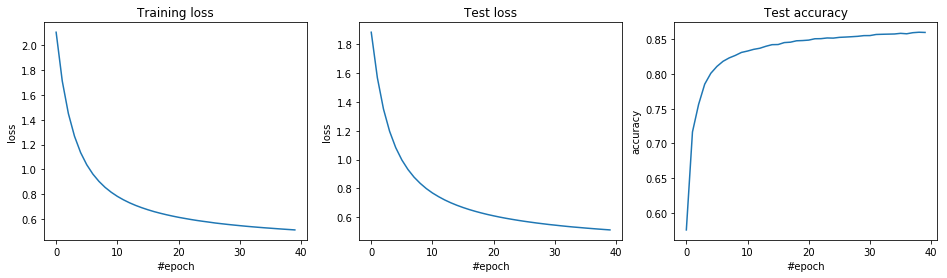

current train loss: 0.5107
test loss: 0.5127, test acc: 0.8595


In [30]:
# Learn it
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 0.001,
                    'momentum': 0.9}
optimizer_state = {}
n_epoch = 40
batch_size = 128

_ = fit_net(cnet, criterion, optimizer_config, optimizer_state, n_epoch, batch_size,
        False, X_train_compressed, Y_train, X_test=X_test_compressed, Y_test=Y_test)

In [31]:
# Now chop off decoder part
autoencoder.removebyidx(compression_module_idx+1)

# And add learned layers ontop.
autoencoder.add(cnet[0])
autoencoder.add(cnet[1])
autoencoder

Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 30
BatchNormalization
ChannelwiseScaling
ReLU
Linear 30 -> 10
LogSoftMax

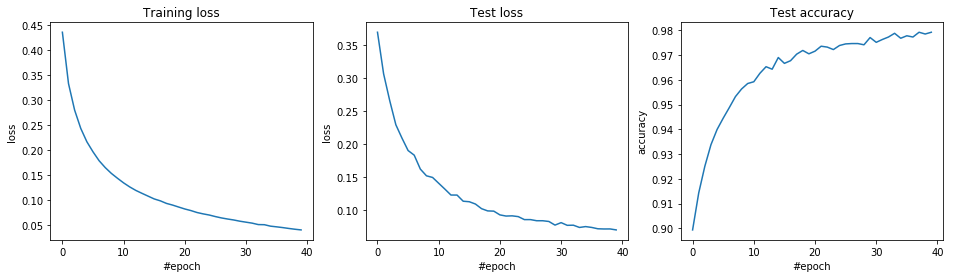

current train loss: 0.0401
test loss: 0.0700, test acc: 0.9792


In [32]:
# Now optimize whole model
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate' : 0.001,
                    'momentum': 0.9}
optimizer_state = {}
n_epoch = 40
batch_size = 256

_ = fit_net(autoencoder, criterion, optimizer_config, optimizer_state, n_epoch, batch_size,
        False, X_train, Y_train, X_test=X_test, Y_test=Y_test)